In [102]:
1+3

4

In [3]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display
from typing import Annotated
from langgraph.graph.message import add_messages
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage


class State(TypedDict):
    extra_message : str
    messages : Annotated[list, add_messages]

In [4]:
from dotenv import load_dotenv
load_dotenv()
import os

from langchain_groq import ChatGroq


#os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


llm=ChatGroq(model="qwen-2.5-32b")
#llm = ChatOpenAI(model="gpt-4o")
result=llm.invoke("Hello")
result


AIMessage(content='Hello! How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 30, 'total_tokens': 40, 'completion_time': 0.05, 'prompt_time': 0.003725157, 'queue_time': 0.048894283000000004, 'total_time': 0.053725157}, 'model_name': 'qwen-2.5-32b', 'system_fingerprint': 'fp_c527211fd1', 'finish_reason': 'stop', 'logprobs': None}, id='run-9da39570-8dac-433b-819c-135c8e46cedb-0', usage_metadata={'input_tokens': 30, 'output_tokens': 10, 'total_tokens': 40})

In [5]:
def step_1(state):
    print("---Step 1---")
    return {"messages": [llm.invoke(state["messages"])], "extra_message": "Used German Language"}


def step_2(state):
    print("---Step 2---")
    return {"messages": [llm.invoke(state["messages"])], "extra_message": "Used Hindi Language"}


def step_3(state):
    print("---Step 3---")
    return {"messages": [llm.invoke(state["messages"])], "extra_message": "Used Marathi Lanaguage"}

def step_4(state):
    print("---Step 4---")
    pass

def step_5(state):
    print("---Step 5---")
    return {"messages": [llm.invoke(state["messages"])], "extra_message": "Used English Lanaguage"}

def should_continue(state: State):
    print("should_continue XXXX ",state)
    input = state.get('extra_message',None)
    print("should_continue XXXX ",input)
    if input:
        return "step_2"
    return "step_5"

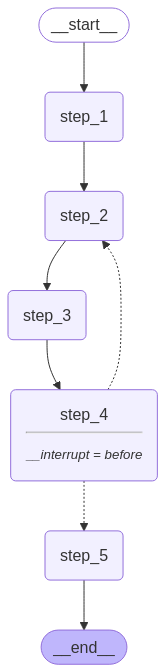

In [6]:
builder = StateGraph(State)
builder.add_node("step_1", step_1)
builder.add_node("step_2", step_2)
builder.add_node("step_3", step_3)
builder.add_node("step_4", step_4)
builder.add_node("step_5", step_5)

builder.add_edge(START, "step_1")
builder.add_edge("step_1", "step_2")
builder.add_edge("step_2", "step_3")
builder.add_edge("step_3", "step_4")
builder.add_conditional_edges("step_4", should_continue, ["step_5", "step_2"])
builder.add_edge("step_5", END)

# Set up memory
memory = MemorySaver()

# Add
graph = builder.compile(checkpointer=memory, interrupt_before=["step_4"])
# graph = builder.compile(checkpointer=memory)

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
# Input
initial_input = {"messages": "What is Love in 3 Words", "extra_message": ""}

# Thread
thread = {"configurable": {"thread_id": "1"}}

for event in graph.stream(initial_input, thread, stream_mode="values"):
    print(event)

state = graph.get_state(thread)
state.next


{'extra_message': '', 'messages': [HumanMessage(content='What is Love in 3 Words', additional_kwargs={}, response_metadata={}, id='57e0f33f-6f1a-4735-8a57-4e04cba868ce')]}
---Step 1---
{'extra_message': 'Used German Language', 'messages': [HumanMessage(content='What is Love in 3 Words', additional_kwargs={}, response_metadata={}, id='57e0f33f-6f1a-4735-8a57-4e04cba868ce'), AIMessage(content='Emotional Connection Intimacy', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 7, 'prompt_tokens': 36, 'total_tokens': 43, 'completion_time': 0.035, 'prompt_time': 0.004371718, 'queue_time': 0.048787320999999995, 'total_time': 0.039371718}, 'model_name': 'qwen-2.5-32b', 'system_fingerprint': 'fp_c527211fd1', 'finish_reason': 'stop', 'logprobs': None}, id='run-185d7c50-41c9-42f2-91f4-b4c168b3c175-0', usage_metadata={'input_tokens': 36, 'output_tokens': 7, 'total_tokens': 43})]}
---Step 2---
{'extra_message': 'Used Hindi Language', 'messages': [HumanMessage(content='Wha

('step_4',)

In [8]:
print("Current state!")
print(graph.get_state(thread).values)


Current state!
{'extra_message': 'Used Marathi Lanaguage', 'messages': [HumanMessage(content='What is Love in 3 Words', additional_kwargs={}, response_metadata={}, id='57e0f33f-6f1a-4735-8a57-4e04cba868ce'), AIMessage(content='Emotional Connection Intimacy', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 7, 'prompt_tokens': 36, 'total_tokens': 43, 'completion_time': 0.035, 'prompt_time': 0.004371718, 'queue_time': 0.048787320999999995, 'total_time': 0.039371718}, 'model_name': 'qwen-2.5-32b', 'system_fingerprint': 'fp_c527211fd1', 'finish_reason': 'stop', 'logprobs': None}, id='run-185d7c50-41c9-42f2-91f4-b4c168b3c175-0', usage_metadata={'input_tokens': 36, 'output_tokens': 7, 'total_tokens': 43}), AIMessage(content='Do you need more information on love or help with something else?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 52, 'total_tokens': 66, 'completion_time': 0.07, 'prompt_time': 0.005274735

In [9]:

graph.update_state(thread, {"messages": HumanMessage(content="What is Love"), "extra_message": "XX"})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f00a812-990d-6c29-8004-f86f430cb455'}}

In [10]:
for event in graph.stream(None, thread, stream_mode="values"):
    print(event)

{'extra_message': 'XX', 'messages': [HumanMessage(content='What is Love in 3 Words', additional_kwargs={}, response_metadata={}, id='57e0f33f-6f1a-4735-8a57-4e04cba868ce'), AIMessage(content='Emotional Connection Intimacy', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 7, 'prompt_tokens': 36, 'total_tokens': 43, 'completion_time': 0.035, 'prompt_time': 0.004371718, 'queue_time': 0.048787320999999995, 'total_time': 0.039371718}, 'model_name': 'qwen-2.5-32b', 'system_fingerprint': 'fp_c527211fd1', 'finish_reason': 'stop', 'logprobs': None}, id='run-185d7c50-41c9-42f2-91f4-b4c168b3c175-0', usage_metadata={'input_tokens': 36, 'output_tokens': 7, 'total_tokens': 43}), AIMessage(content='Do you need more information on love or help with something else?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 52, 'total_tokens': 66, 'completion_time': 0.07, 'prompt_time': 0.005274735, 'queue_time': 0.050891394, 'total